In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import warnings
import pandas as pd
import pickle
import math
import scipy.stats as sts
from cvxopt import matrix, solvers
import json

from tqdm.notebook import tqdm
from collections import defaultdict
from cycler import cycler
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from einops import rearrange

import quantpy as qp
from quantpy.tomography.interval import ConfidenceInterval, _pop_hidden_keys, Mode
from quantpy.routines import _left_inv
from quantpy.stats import l2_mean, l2_variance
from quantpy.geometry import hs_dst, if_dst, trace_dst

titlesize = 48
labelsize = 52
legendsize = 32
xticksize = 40
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

warnings.filterwarnings('ignore', category=np.ComplexWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
with open('../data/states.pkl', 'rb') as f:
    states = pickle.load(f)
states

,name,state,title,povm,n_meas
0,zero1,"Quantum object\narray([[1.+0.j, 0.+0.j],\n ...",$|0\rangle$,proj-set,1000
1,pure1,"Quantum object\narray([[0.85355339+0.j , 0.25...",$\cos\frac{\pi}{8}|0\rangle + \sin\frac{\pi}{8...,proj-set,1000
2,fullymixed1,"Quantum object\narray([[0.5+0.j, 0. +0.j],\n ...",1-qubit fully mixed state,proj-set,1000
3,zero2,"Quantum object\narray([[1.+0.j, 0.+0.j, 0.+0.j...",$|00\rangle$,proj-set,10000
4,ghz2,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",$|\Phi^+\rangle$,proj-set,10000
5,fullymixed2,"Quantum object\narray([[0.25+0.j, 0. +0.j, 0....",2-qubit fully mixed state,proj-set,10000
6,ghz3,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",3-qubit GHZ state,proj-set,100000


In [3]:
with open('../data/processes.pkl', 'rb') as f:
    processes = pickle.load(f)
processes

,name,process,title,povm,n_meas
0,hadamard,Quantum channel with Choi matrix\narray([[ 0.5...,Hadamard gate,proj-set,1000
1,rxpi2,Quantum channel with Choi matrix\narray([[0.5+...,$RX(\pi/2)$,proj-set,1000
2,rypi2,Quantum channel with Choi matrix\narray([[ 0.5...,$RY(\pi/2)$,proj-set,1000
3,dep1,Quantum channel with Choi matrix\narray([[0.5+...,Fully depolarizing 1-qubit,proj-set,1000
4,cnot,Quantum channel with Choi matrix\narray([[1.+0...,CNOT,proj-set,100000
5,ms,Quantum channel with Choi matrix\narray([[ 0.5...,Mølmer–Sørensen gate,proj-set,100000


In [14]:
input_states = [[0.5, 0.2886751345948129, 0.2886751345948129, 0.28867513459481287],
                [0.5, 0.2886751345948129, -0.2886751345948129, -0.28867513459481287],
                [0.5, -0.2886751345948129, 0.2886751345948129, -0.28867513459481287],
                [0.5, -0.2886751345948129, -0.2886751345948129, 0.28867513459481287]]
povm_matrix = [[[ 0.5,  0.5,  0. ,  0. ],
        [ 0.5, -0.5,  0. ,  0. ]],

       [[ 0.5,  0. ,  0.5,  0. ],
        [ 0.5,  0. , -0.5,  0. ]],

       [[ 0.5,  0. ,  0. ,  0.5],
        [ 0.5,  0. ,  0. , -0.5]]]
# results = [[[7870, 2130], [2066, 7934], [7899, 2101]],
#  [[2099, 7901], [7927, 2073], [7870, 2130]],
#  [[2183, 7817], [2086, 7914], [2146, 7854]],
#  [[7915, 2085], [7823, 2177], [2114, 7886]]]
target_channel = list(processes.iloc[0]["process"].choi.bloch)

input_states = [qp.Qobj(bloch) for bloch in input_states]
povm_matrix = np.asarray(povm_matrix)
# results = np.asarray(results)
target_channel = qp.Channel(qp.Qobj(target_channel))
tmg = qp.ProcessTomograph(target_channel, input_states=input_states)
tmg.experiment(10000, "proj-set")
# tmg.results = results

In [20]:
interval = qp.MomentInterval(tmg)
interval([0.5, 0.75, 0.9])[0]

array([0.01529795, 0.01764183, 0.01983802])

In [15]:
tmg.results.tolist()

[[[7896, 2104], [2107, 7893], [7916, 2084]],
 [[2086, 7914], [7902, 2098], [7966, 2034]],
 [[2203, 7797], [2124, 7876], [2031, 7969]],
 [[7863, 2137], [7918, 2082], [2186, 7814]]]

In [21]:
tmg.point_estimate(cptp=False).choi.bloch

array([ 5.00000000e-01,  1.20000000e-03,  1.27500000e-03,  2.47500000e-03,
       -2.77555756e-17, -3.63730670e-03, -1.42894192e-03,  5.05109317e-01,
        0.00000000e+00, -6.49519053e-03,  5.01818420e-01,  8.87676039e-03,
        5.55111512e-17,  4.96665569e-01, -4.33012702e-05,  4.54663337e-03])

In [5]:
tmg.point_estimate()

Quantum channel with Choi matrix
array([[ 0.50321637+0.00000000e+00j,  0.49729217+2.15697599e-03j,
         0.49706507+2.56306202e-03j, -0.50099188-4.82421850e-03j],
       [ 0.49729217-2.15697599e-03j,  0.49678363-2.16840434e-19j,
         0.49479818+2.48192079e-03j, -0.49706507-2.56306202e-03j],
       [ 0.49706507-2.56306202e-03j,  0.49479818-2.48192079e-03j,
         0.49856023+0.00000000e+00j, -0.49742196-2.79553158e-03j],
       [-0.50099188+4.82421850e-03j, -0.49706507+2.56306202e-03j,
        -0.49742196+2.79553158e-03j,  0.50143977+0.00000000e+00j]])

In [30]:
results[0].tolist()

[[7826, 2174], [2050, 7950], [7920, 2080]]

In [22]:
target_channel

Quantum channel with Choi matrix
array([[ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j],
       [ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j],
       [ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j],
       [-0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j]])

In [17]:
processes.iloc[0]["process"].choi.bloch

array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0.5, 0. , 0. ,
       0.5, 0. , 0. ])

In [48]:
channel = processes.iloc[1]["process"]
dim_in = dim_out = 2 ** channel.n_qubits
dim = dim_in * dim_out
# bloch_indices1 = [i for i in range(dim ** 2) if i % (dim_out ** 2) == 0]
trivial_indices = list(range(0, dim ** 2, dim_out ** 2))
np.eye(dim ** 2)[trivial_indices] @ channel.choi.bloch, 1 / dim_in

(array([0.5, 0. , 0. , 0. ]), 0.5)

In [25]:
channel.choi.bloch[bloch_indices]

[0, 4, 8, 12]

In [ ]:
qp.Channel()

In [14]:
tmg.tomographs[0].povm_matrix

array([[[ 0.5,  0.5,  0. ,  0. ],
        [ 0.5, -0.5,  0. ,  0. ]],

       [[ 0.5,  0. ,  0.5,  0. ],
        [ 0.5,  0. , -0.5,  0. ]],

       [[ 0.5,  0. ,  0. ,  0.5],
        [ 0.5,  0. ,  0. , -0.5]]])

In [3]:
target_state = qp.Qobj([0.5, 0, 0, 0.5])

In [42]:
with open("../input.json", "r") as fp:
    input_data = json.load(fp)

output = dict()

results = np.asarray(input_data["outcomes"])
povm_matrix = np.asarray(input_data["povm_matrix"])

state = qp.Qobj(povm_matrix[0, 0])
n_measurements = results.sum(-1, dtype=float)
tmg = qp.StateTomograph(state)
tmg.experiment(n_measurements, povm_matrix)
tmg.raw_results = results
output["state"] = list(tmg.point_estimate(physical=False).bloch)

target_state = qp.Qobj(input_data["target_state"])
interval = qp.MomentFidelityStateInterval(tmg, target_state=target_state)
interval.setup()
(fidelity_min, fidelity_max), _ = interval(input_data["conf_levels"])
output["fidelity_min"] = list(fidelity_min)
output["fidelity_max"] = list(fidelity_max)

In [13]:
fidelity_min

array([0.49799283, 0.49724833, 0.49652007])

In [12]:
output["state"]

[0.5, -0.0014199999999999814, -0.002310000000000039, 0.44977]

In [11]:
target_state

Quantum object
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [9]:
output

{'state': [0.5, -0.0014199999999999814, -0.002310000000000039, 0.44977],
 'fidelity_min': [0.4979928303036564, 0.4972483320056992, 0.49652006537747223],
 'fidelity_max': [0.5020071696963437, 0.5027516679943007, 0.5034799346225277]}

In [7]:
output["state"]

[0.5, -0.0014199999999999814, -0.002310000000000039, 0.44977]

In [50]:
target_state = states.iloc[0].state
dim = 2 ** target_state.n_qubits
n_meas = 10000
dep_channel = qp.channel.depolarizing(0., n_qubits=target_state.n_qubits)
state = dep_channel.transform(target_state)

new_tmg = qp.StateTomograph(state)
new_tmg.experiment(n_meas)
new_tmg.raw_results = results

fidelity = np.dot(target_state.bloch, state.bloch) * dim
interval = qp.MomentFidelityStateInterval(tmg, target_state=target_state)
# epsilons = np.logspace(-5, -0.01, 1000)
epsilons = np.linspace(1e-4, 1-1e-4, 1000)
conf_levels = 1 - epsilons
(dist_min, dist_max), conf_levels = interval(input_data["conf_levels"])

In [51]:
interval = qp.MomentFidelityStateInterval(new_tmg, target_state=target_state)
(dist_min, dist_max), conf_levels = interval(input_data["conf_levels"])
dist_min

array([0.99411327, 0.9916752 , 0.98927072])

In [52]:
interval = qp.MomentFidelityStateInterval(tmg, target_state=target_state)
(dist_min, dist_max), conf_levels = interval(input_data["conf_levels"])
dist_min

array([0.49411327, 0.4916749 , 0.48927072])

In [46]:
new_tmg.n_measurements

array([10000., 10000., 10000.])

In [47]:
tmg.n_measurements

array([10000., 10000., 10000.])

In [ ]:
interval = qp.MomentFidelityStateInterval(tmg, target_state=target_state)
(dist_min, dist_max), conf_levels = interval(input_data["conf_levels"])
dist_min

In [30]:
tmg.raw_results

array([[ 4955,  5045],
       [ 4943,  5057],
       [10000,     0]])

In [27]:
tmg.point_estimate(physical=False).bloch

array([ 0.5  , -0.023,  0.012,  0.5  ])

In [18]:
state

Quantum object
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [19]:
target_state

Quantum object
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [17]:
dist_min

array([0.98138501, 0.97367443, 0.96607196])

In [5]:
dist_min

array([0.91333265, 0.94155443, 0.94446131, 0.94625971, 0.94758267,
       0.94863699, 0.94951744, 0.95027568, 0.95094309, 0.95154019,
       0.95208119, 0.95257633, 0.95303325, 0.9534578 , 0.95385456,
       0.95422721, 0.9545787 , 0.95491149, 0.95522762, 0.95552881,
       0.95581652, 0.956092  , 0.95635634, 0.95661048, 0.95685524,
       0.95709134, 0.95731944, 0.95754012, 0.9577539 , 0.95796124,
       0.95816254, 0.95835819, 0.95854854, 0.95873388, 0.9589145 ,
       0.95909066, 0.95926261, 0.95943056, 0.95959471, 0.95975525,
       0.95991236, 0.96006619, 0.9602169 , 0.96036462, 0.96050949,
       0.96065163, 0.96079115, 0.96092815, 0.96106275, 0.96119502,
       0.96132507, 0.96145298, 0.96157882, 0.96170266, 0.96182459,
       0.96194467, 0.96206295, 0.96217951, 0.96229439, 0.96240766,
       0.96251935, 0.96262954, 0.96273824, 0.96284553, 0.96295143,
       0.96305598, 0.96315924, 0.96326122, 0.96336198, 0.96346154,
       0.96355993, 0.96365719, 0.96375335, 0.96384843, 0.96394

In [97]:
tmg = qp.StateTomograph(state)
tmg.experiment(n_meas)
state_hat = tmg.point_estimate(physical=False)
state_hat

Quantum object
array([[0.82 +0.j   , 0.232-0.245j],
       [0.232+0.245j, 0.18 +0.j   ]])

In [98]:
new_tmg = qp.StateTomograph(qp.Qobj([0, 0, .5]))
new_tmg.experiment(n_meas, tmg.povm_matrix)
new_tmg.raw_results = tmg.raw_results
new_state_hat = new_tmg.point_estimate(physical=False)
new_state_hat

Quantum object
array([[0.82 +0.j   , 0.232-0.245j],
       [0.232+0.245j, 0.18 +0.j   ]])

In [88]:
dists = []
n_repeats = 10000
for _ in range(n_repeats):
    tmg = qp.StateTomograph(state)
    tmg.experiment(n_meas)
    state_hat = tmg.point_estimate(physical=False)
    dists.append(state_hat.bloch @ target_state.bloch * dim)
dists = np.asarray(sorted(dists))
ind = np.where(dists > fidelity)[0][0]
emp_dist_min, emp_dist_max = [], []
emp_cl = []
corrected_len = min(ind, n_repeats - ind)
for i in range(corrected_len):
    emp_dist_min.append(dists[ind - i])
    emp_dist_max.append(dists[ind + i])
    emp_cl.append((2 * i + 1) / (corrected_len * 2 + 1))
emp_cl = np.asarray(emp_cl)

In [89]:
corrected_len

4993

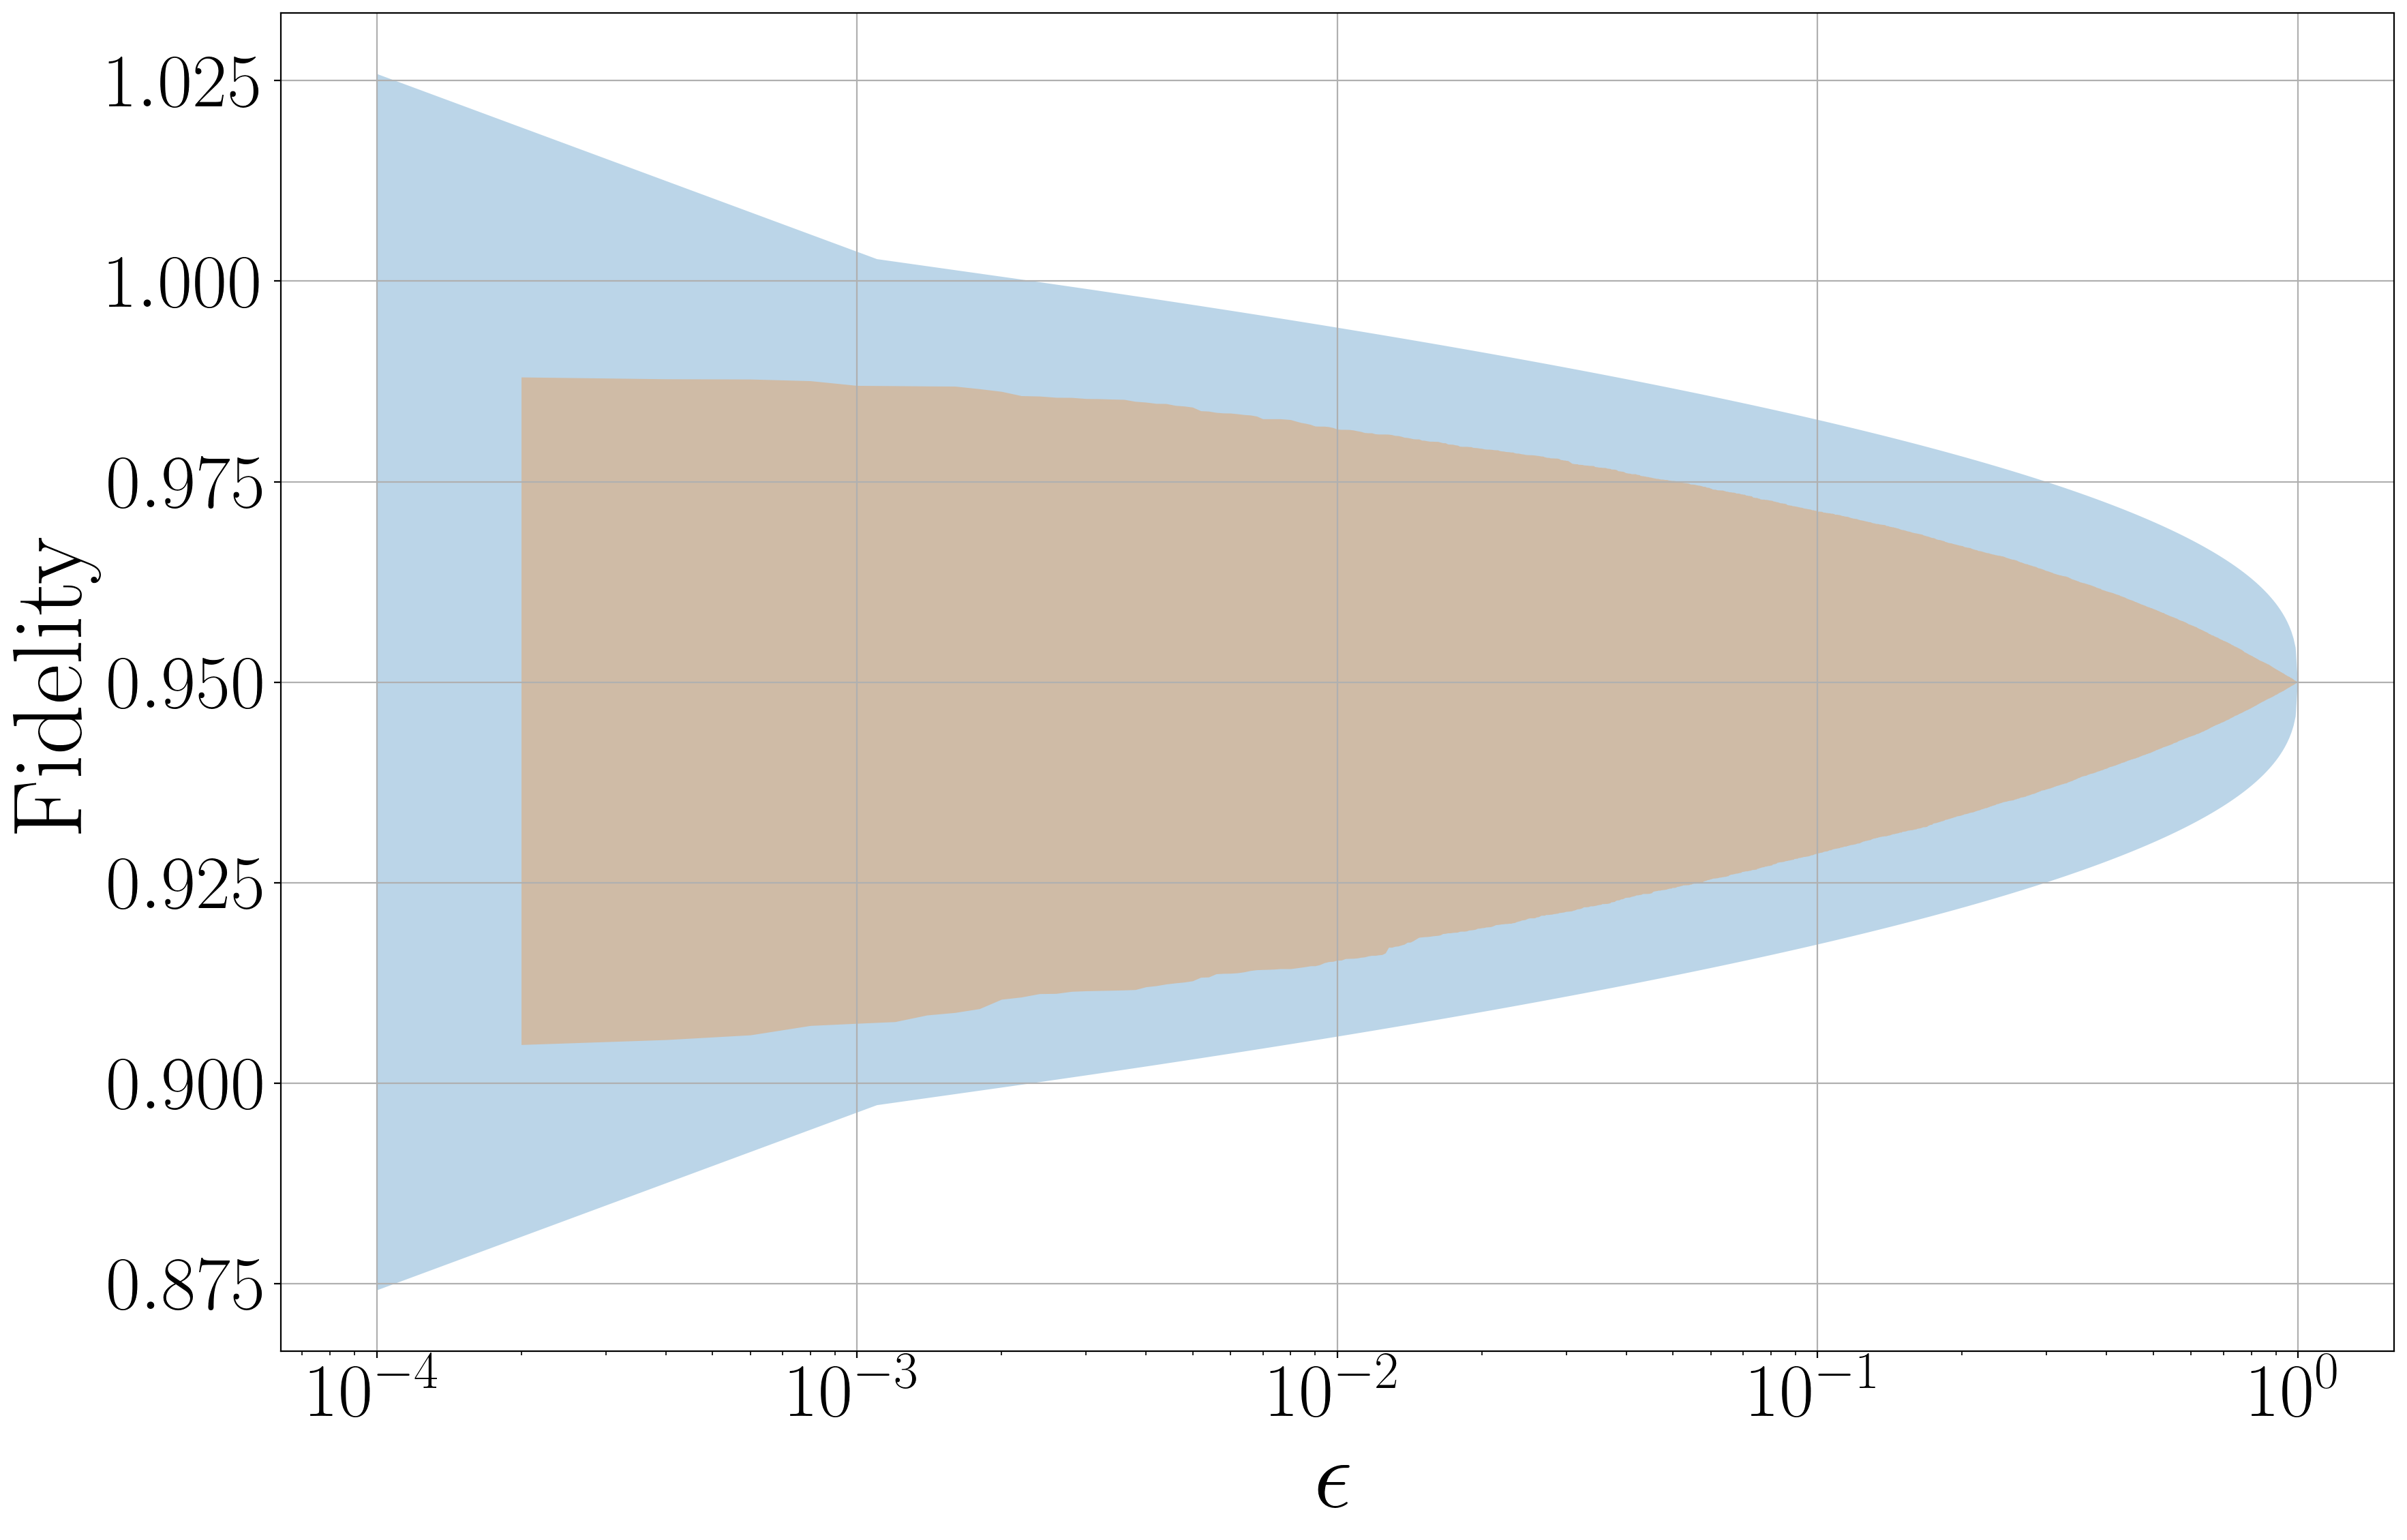

In [92]:
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('Fidelity')
plt.grid()
plt.fill_between(epsilons, dist_min, dist_max, alpha=0.3)
plt.fill_between(1 - emp_cl, emp_dist_min, emp_dist_max, alpha=0.3)
plt.xscale('log')